<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText xfeat category_encoders texthero geopy umap transformers
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [3]:
!pip install MulticoreTSNE

In [4]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model
from tqdm import tqdm

import torch
import transformers
from transformers import BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification

from sklearn.decomposition import PCA, TruncatedSVD
from MulticoreTSNE import MulticoreTSNE as TSNE
import umap.umap_ as umap

sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPUT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

os.chdir(CODE_PATH)
from feature_engine import *
from nlp_feature import *
from util import AbstractBaseBlock, WrapperBlock

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:

import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_PATH, name))

In [6]:
train_df = read_csv("train")
test_df = read_csv("test")
whole_df = pd.concat([train_df, test_df])

run
run


In [7]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [43]:
BSV = BertSequenceVectorizer()
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [44]:
def create_description_feature(input_df):
  BSV = BertSequenceVectorizer()
  out_df = pd.DataFrame()
  out_df["description"] = input_df["description"].fillna("NaN").progress_apply(lambda x: BSV.vectorize(x))
  return out_df.add_suffix("_feature")

In [45]:
description_feature_df = create_description_feature(train_df)


 43%|████▎     | 5115/12026 [01:11<01:38, 70.30it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors

100%|██████████| 12026/12026 [02:52<00:00, 69.72it/s]


In [11]:
# def create_reduction_bert_feature(methods, N=2):
#   out_df = pd.DataFrame(
#       np.stack(description_feature_df["description_feature"])
#   )

#   method = methods(n_components=N)
#   transformed = method.fit_transform(out_df)
#   output_df = pd.DataFrame(
#       transformed, 
#       columns=[f'{methods}_{n}_feature' for n in range(N)]
#   )
#   return output_df

In [46]:
class CreateReductionBertFeature(AbstractBaseBlock):
  def __init__(self, methods, n_components=3):
    self.n_components = n_components
    self.methods =methods

  def fit(self, input_df):
    self.method = self.methods(self.n_components)
    return self.transform(input_df)

  def transform(self, input_df):
    tmp_df = pd.DataFrame(
        np.stack(description_feature_df["description_feature"])
    )

    transformed = self.method.fit_transform(tmp_df)

    out_df = pd.DataFrame(
        transformed,
        columns=[f'{self.methods}_{n}_feature' for n in range(self.n_components)]
    )

    return out_df

In [47]:
CreateReductionBertFeature(methods=TruncatedSVD, n_components=3).fit(train_df)

,<class 'sklearn.decomposition._truncated_svd.TruncatedSVD'>_0_feature,<class 'sklearn.decomposition._truncated_svd.TruncatedSVD'>_1_feature,<class 'sklearn.decomposition._truncated_svd.TruncatedSVD'>_2_feature
0,11.680549,8.394503,0.824257
1,11.680559,8.394434,0.823855
2,14.404679,-1.289852,-1.171960
3,13.532034,1.552825,-0.243856
4,14.088096,-1.337839,-2.206608
...,...,...,...
12021,11.680559,8.394387,0.823063
12022,13.273450,-4.492098,-0.768004
12023,13.840510,-2.103925,-1.321764
12024,6.102664,-6.168097,6.601360


In [14]:
material_df = read_csv("material")
technique_df = read_csv("technique")
collection = read_csv("object_collection")

run
run
run


In [15]:
material_df.groupby("object_id")["name"].apply(list)

object_id
000405d9a5e3f49fc49d    [photographic paper, cardboard]
001020bd00b149970f78         [oil paint (paint), panel]
0011d6be41612ec9eae3        [oil paint (paint), canvas]
0012765f7a97ccc3e9e9               [photographic paper]
00133be3ff222c9b74b0                            [paper]
                                     ...               
fff1d87d79953ddab2c6         [oil paint (paint), panel]
fff4bbb55fd7702d294e               [photographic paper]
fffbe07b997bec00e203    [photographic paper, cardboard]
fffd43b134ba7197d890               [photographic paper]
ffff22ea12d7f99cff31        [paper, photographic paper]
Name: name, Length: 23586, dtype: object

In [16]:
collection.groupby("object_id")["name"].apply(list)

object_id
001020bd00b149970f78    [paintings]
0011d6be41612ec9eae3    [paintings]
00133be3ff222c9b74b0       [prints]
00181d86ff1a7b95864e    [paintings]
001c52ae28ec106d9cd5    [paintings]
                           ...     
ffe7e1649e805918e42c       [prints]
ffee34705ea44e1a0f79       [prints]
ffefbe1faf771aa4f790       [prints]
fff08e76cbb969eaddc7       [prints]
fff1d87d79953ddab2c6    [paintings]
Name: name, Length: 14160, dtype: object

In [17]:
technique_df.groupby("object_id")["name"].apply(list)

object_id
000405d9a5e3f49fc49d                        [albumen print]
0012765f7a97ccc3e9e9    [salted paper print, albumen print]
00133be3ff222c9b74b0                              [etching]
0017be8caa87206532cb                        [albumen print]
001f4c71b4d53497b531                            [engraving]
                                       ...                 
fff4bbb55fd7702d294e                        [albumen print]
fffbe07b997bec00e203                        [albumen print]
fffd1675758205748d7f                        [albumen print]
fffd43b134ba7197d890                        [albumen print]
ffff22ea12d7f99cff31                        [albumen print]
Name: name, Length: 17329, dtype: object

In [18]:
mat_col = pd.concat([material_df, collection], axis=0).reset_index(drop=True)
mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
col_tec = pd.concat([collection, technique_df], axis=0).reset_index(drop=True)
mat_col_tec = pd.concat([material_df, collection, technique_df], axis=0).reset_index(drop=True)

In [19]:
mat_col_tec['name'].value_counts().head(30)

paper                     13283
prints                     9905
photographic paper         7615
etching                    5936
engraving                  5563
albumen print              5544
paintings                  4200
oil paint (paint)          4131
cardboard                  4074
canvas                     2220
panel                      1695
gelatin silver print       1158
glass                       757
letterpress printing        722
copper (metal)              355
drypoint                    229
salted paper print          221
baryta paper                208
slide                       203
painting                    184
steel engraving             161
velvet (fabric weave)       149
metal                       146
leather                     119
collotype                   103
wood (plant material)        99
ambrotype                    74
inkjet print                 68
celluloid (cellulosic)       68
RC paper                     54
Name: name, dtype: int64

In [20]:
model_size = {
    "material":20,
    "techique":8,
    "collection":3,
    "material_collection":20,
    "material_techique":20,
    "collection_technique":10, 
    "material_collection_techique":25
}
n_iter = 100

In [21]:
from gensim.models import word2vec
model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}

n_iter = 100
w2v_dfs = []
for df, df_name in zip(
        [
            material_df, collection, technique_df,
            mat_col, mat_tec, col_tec, mat_col_tec
        ], [
            "material", "collection", "technique",
            "material_collection",
            "material_technique",
            "collection_technique",
            "material_collection_technique"
        ]):
    df_group = df.groupby("object_id")["name"].apply(list).reset_index()
    # Word2Vecの学習
    w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                  size=model_size[df_name],
                                  min_count=1,
                                  window=1,
                                  iter=n_iter)

    # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
    sentence_vectors = df_group["name"].progress_apply(
        lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
    sentence_vectors = np.vstack([x for x in sentence_vectors])
    sentence_vector_df = pd.DataFrame(sentence_vectors,
                                      columns=[f"{df_name}_w2v_{i}"
                                               for i in range(model_size[df_name])])
    sentence_vector_df.index = df_group["object_id"]
    w2v_dfs.append(sentence_vector_df)

100%|██████████| 23953/23953 [00:00<00:00, 43690.17it/s]


In [22]:
OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])


class Word2VecBlock(AbstractBaseBlock):
  def __init__(self, model_size:tuple):
    self.model_size = model_size

  def fit(self, input_df, y=None):
    material_df = read_csv("material")
    technique_df = read_csv("technique")
    collection = read_csv("object_collection")

    mat_col = pd.concat([material_df, collection], axis=0).reset_index(drop=True)
    mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
    col_tec = pd.concat([collection, technique_df], axis=0).reset_index(drop=True)
    mat_col_tec = pd.concat([material_df, collection, technique_df], axis=0).reset_index(drop=True)

    w2v_dfs = []
    for df, df_name in zip(
            [
                material_df, collection, technique_df,
                mat_col, mat_tec, col_tec, mat_col_tec
            ], [
                "material", "collection", "technique",
                "material_collection",
                "material_technique",
                "collection_technique",
                "material_collection_technique"
            ]):
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()
        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size[df_name],
                                      min_count=1,
                                      window=1,
                                      iter=100)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].progress_apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{df_name}_w2v_{i}"
                                                  for i in range(model_size[df_name])])
        sentence_vector_df.index = df_group["object_id"]
        w2v_dfs.append(sentence_vector_df)

    tmp_2 = pd.merge(w2v_dfs[0], w2v_dfs[1], on='object_id', how="left")
    tmp_3 = pd.merge(w2v_dfs[2], w2v_dfs[3], on='object_id', how="left")
    tmp_4 = pd.merge(w2v_dfs[4], w2v_dfs[5], on='object_id', how="left")
    tmp_5 = pd.merge(tmp_2, w2v_dfs[6], on="object_id", how="left")
    tmp_2 = pd.merge(tmp_3, tmp_4, on="object_id", how="left")
    self._df = pd.merge(tmp_5, tmp_2, on="object_id", how="left")

    return self.transform(input_df)
      
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df = left_join(input_df, self._df)
    return out_df


In [23]:
Word2VecBlock(model_size=model_size).fit(train_df)

100%|██████████| 23953/23953 [00:00<00:00, 40762.39it/s]


,material_w2v_0,material_w2v_1,material_w2v_2,material_w2v_3,material_w2v_4,material_w2v_5,material_w2v_6,material_w2v_7,material_w2v_8,material_w2v_9,material_w2v_10,material_w2v_11,material_w2v_12,material_w2v_13,material_w2v_14,material_w2v_15,material_w2v_16,material_w2v_17,material_w2v_18,material_w2v_19,collection_w2v_0,collection_w2v_1,collection_w2v_2,material_collection_technique_w2v_0,material_collection_technique_w2v_1,material_collection_technique_w2v_2,material_collection_technique_w2v_3,material_collection_technique_w2v_4,material_collection_technique_w2v_5,material_collection_technique_w2v_6,material_collection_technique_w2v_7,material_collection_technique_w2v_8,material_collection_technique_w2v_9,material_collection_technique_w2v_10,material_collection_technique_w2v_11,material_collection_technique_w2v_12,material_collection_technique_w2v_13,material_collection_technique_w2v_14,material_collection_technique_w2v_15,material_collection_technique_w2v_16,...,material_collection_w2v_10,material_collection_w2v_11,material_collection_w2v_12,material_collection_w2v_13,material_collection_w2v_14,material_collection_w2v_15,material_collection_w2v_16,material_collection_w2v_17,material_collection_w2v_18,material_collection_w2v_19,material_technique_w2v_0,material_technique_w2v_1,material_technique_w2v_2,material_technique_w2v_3,material_technique_w2v_4,material_technique_w2v_5,material_technique_w2v_6,material_technique_w2v_7,material_technique_w2v_8,material_technique_w2v_9,material_technique_w2v_10,material_technique_w2v_11,material_technique_w2v_12,material_technique_w2v_13,material_technique_w2v_14,material_technique_w2v_15,material_technique_w2v_16,material_technique_w2v_17,material_technique_w2v_18,material_technique_w2v_19,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
0,-0.562009,0.709349,0.232438,-0.662264,0.350907,-0.839168,-0.283730,-0.204160,-0.023791,0.541120,0.947288,-0.286052,-0.817671,0.230708,-0.318740,-0.909275,-0.545550,0.071220,0.783707,-0.346903,0.561820,0.120673,1.478385,-0.004740,0.544465,0.578992,-1.199435,0.087305,0.288497,0.036067,-0.052730,-0.029842,-0.178061,1.086646,0.168561,-1.325595,0.223550,-0.113252,-0.676878,0.616267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.990437,-0.256014,1.625835,0.060302,0.193961,0.212433,0.394572,0.126713,1.267567,0.849889,0.065504,0.536048,0.185781,-0.217301,-0.175062,-0.980308,-1.243213,-1.091511,0.425529,0.727675,NaN,NaN,NaN,-0.693054,0.243216,0.632485,-0.075437,-0.611644,0.692849,0.903772,0.219161,0.909768,0.204268,1.298181,0.874116,0.296587,-0.683991,0.062891,0.797110,-0.301310,...,0.127735,0.590683,0.689307,-0.657133,-0.636153,-0.961601,-1.743176,-0.313917,1.119764,0.565198,-1.687470,0.176016,0.822974,0.070579,-0.871512,0.315052,1.121804,0.206010,0.648539,-0.216984,1.103447,0.680857,0.212155,-0.312379,0.350126,0.686559,-0.882378,-0.114332,0.048588,0.132221,0.200961,0.172115,0.152200,-0.465440,0.009843,0.242579,0.317017,0.212147,0.078240,0.087383
2,-0.168505,0.247368,0.873407,0.395045,-0.012678,0.086288,0.762883,0.016546,0.104153,0.385710,-0.129626,0.175278,0.319153,-0.057047,-0.059603,-0.372596,-1.181146,-0.628906,0.436152,0.437778,NaN,NaN,NaN,-0.184530,0.007546,0.843988,0.032301,-0.677763,0.532107,0.840517,0.104277,0.518268,0.136075,0.607553,0.708465,0.133957,-0.075686,0.285940,0.849206,-0.605255,...,-0.029862,0.358938,0.359120,-0.447285,-0.192599,-0.660621,-1.080217,-0.809662,0.423164,0.470722,-1.160771,0.233275,0.821660,0.247658,-0.715606,-0.124242,0.883925,0.303715,0.003058,0.006006,0.737481,0.686222,0.128993,0.007012,0.408615,0.418358,-1.079722,-0.303898,-0.235736,0.313119,0.382184,0.219797,0.301874,-0.586028,0.

In [24]:
from geopy.geocoders import Nominatim
import numpy as np
production_place = read_csv("production_place")

def place2country(address):
    geolocator = Nominatim(user_agent='sample', timeout=200)
    loc = geolocator.geocode(address, language='en')
    coordinates = (loc.latitude, loc.longitude)
    location = geolocator.reverse(coordinates, language='en')
    country = location.raw['address']['country']
    return country

from tqdm import tqdm_notebook as tqdm

place_list = production_place['name'].unique()
country_dict = {}
for place in tqdm(place_list):
    try:
        country = place2country(place)
        country_dict[place] = country
    except:
        # 国名を取得できない場合はnan
        print(place)
        country_dict[place] = np.nan

run


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Indonesian Archipelago



In [25]:
production_place['country_name'] = production_place['name'].map(country_dict)
production_place["country_name"].value_counts()

Netherlands       10125
France             1704
Belgium            1411
Indonesia           987
Italy               880
Germany             784
United Kingdom      503
Denmark             289
Suriname            282
United States       239
Norway              106
Japan                96
Switzerland          59
India                51
Austria              45
Spain                44
China                42
Iran                 22
Sri Lanka            11
Russia                2
Canada                1
Greece                1
Poland                1
Name: country_name, dtype: int64

In [26]:
OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

class PlaceBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      vc = production_place['country_name'].value_counts()
      use_names = vc[vc >= self.min_count].index

      idx = production_place['country_name'].isin(use_names)
      _use_df = production_place[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['country_name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'Production_Place_name=')

In [27]:
PlaceBlock(min_count=40).fit(train_df)

,Production_Place_name=Austria,Production_Place_name=Belgium,Production_Place_name=China,Production_Place_name=Denmark,Production_Place_name=France,Production_Place_name=Germany,Production_Place_name=India,Production_Place_name=Indonesia,Production_Place_name=Italy,Production_Place_name=Japan,Production_Place_name=Netherlands,Production_Place_name=Norway,Production_Place_name=Spain,Production_Place_name=Suriname,Production_Place_name=Switzerland,Production_Place_name=United Kingdom,Production_Place_name=United States
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12022,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
12023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12024,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      material_df = read_csv('material')
      vc = material_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = material_df['name'].isin(use_names)
      _use_df = material_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'MaterialBlock_name=')

In [29]:
class TechiqueBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      techique_df = read_csv('technique')
      vc = technique_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = technique_df['name'].isin(use_names)
      _use_df = technique_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'TechniqueBlock_name=')

In [37]:
class CollectionBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      collection_df = read_csv('object_collection')
      vc = collection_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = collection_df['name'].isin(use_names)
      _use_df = collection_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'CollectionBlock_name=')

In [31]:
def get_period_of_production(input_df):
  out_df = pd.DataFrame()
  out_df["period_of_production"] = input_df["dating_year_late"] - input_df["dating_year_early"]
  return out_df.fillna(0)

def get_time_between_late_year_and_acqusition(input_df):
  input_df["acquisition_date"] = pd.to_datetime(input_df["acquisition_date"])
  input_df["year"] = input_df["acquisition_date"].dt.year.fillna(0)
  out_df = pd.DataFrame()
  out_df["period_of_acquisition_date"] = input_df["year"]- input_df["dating_year_late"].fillna(0).astype(float)
  return out_df.fillna(0)

In [32]:
class GetLanguageLabel(AbstractBaseBlock):
  """
  言語判定するブロック
  """
  def __init__(self, cols):
    self.cols = cols

  def fit(self, input_df):
    return self.transform(input_df)

  def transform(self, input_df):
    out_df = pd.DataFrame()
    self.model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")
    out_df[self.cols] = input_df[self.cols].fillna("").map(lambda x: self.model.predict(x.replace("\n", ""))[0][0])
    return out_df.add_prefix("lang_label_")


class GetCountWord(AbstractBaseBlock):
  def __init__(self, cols):
    self.cols = cols
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df[self.cols] = input_df[self.cols].fillna("NaN")
    out_df[self.cols] = out_df[self.cols].apply(lambda x: len(x.split()))
    return out_df.add_prefix("count_word_")

In [33]:
from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [121]:
train_df = read_csv("train")
test_df = read_csv('test')
add_feature_block = [
                     WrapperBlock(get_period_of_production),
                     WrapperBlock(get_time_between_late_year_and_acqusition),
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetLanguageLabel("long_title"),
                     GetCountString("title"),
                     GetCountString("description"),
                     GetCountWord("description"),
                     GetCountString("acquisition_credit_line"),
                     GetCountWord("acquisition_credit_line"),
                     GetCountString("long_title"),
                     GetCountString("more_title"),
                     GetCountString("sub_title"),

]

train_feat_df = to_feature(train_df, train_df, add_feature_block, is_train=True)
test_feat_df = to_feature(test_df, test_df, add_feature_block, is_train=False)
print(train_df.shape, test_df.shape)


  0%|          | 0/13 [00:00<?, ?it/s]Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.


create<util.WrapperBlock object at 0x7fb55588d810> 0.005[s]
12026 12026
create<util.WrapperBlock object at 0x7fb554c6ca50> 0.014[s]
12026 12026



 23%|██▎       | 3/13 [00:00<00:01,  7.15it/s]

create<__main__.GetLanguageLabel object at 0x7fb554c6c650> 0.374[s]
12026 12026



 31%|███       | 4/13 [00:00<00:02,  4.12it/s]

create<__main__.GetLanguageLabel object at 0x7fb554a98a50> 0.466[s]
12026 12026



100%|██████████| 13/13 [00:01<00:00,  8.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

create<__main__.GetLanguageLabel object at 0x7fb554a98e90> 0.418[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fb554a98790> 0.012[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fb5557bb650> 0.008[s]
12026 12026
create<__main__.GetCountWord object at 0x7fb5557bbd50> 0.024[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fb5557bbdd0> 0.007[s]
12026 12026
create<__main__.GetCountWord object at 0x7fb5557bb2d0> 0.008[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fb5557bbe10> 0.009[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fb556067510> 0.009[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fb5557e4fd0> 0.007[s]
12026 12026
create<util.WrapperBlock object at 0x7fb55588d810> 0.004[s]
12008 12008


create<util.WrapperBlock object at 0x7fb554c6ca50> 0.016[s]
12008 12008



 23%|██▎       | 3/13 [00:00<00:01,  7.30it/s]Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.


create<__main__.GetLanguageLabel object at 0x7fb554c6c650> 0.371[s]
12008 12008



 31%|███       | 4/13 [00:00<00:02,  3.78it/s]

create<__main__.GetLanguageLabel object at 0x7fb554a98a50> 0.548[s]
12008 12008



100%|██████████| 13/13 [00:01<00:00,  8.35it/s]

create<__main__.GetLanguageLabel object at 0x7fb554a98e90> 0.395[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fb554a98790> 0.008[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fb5557bb650> 0.008[s]
12008 12008
create<__main__.GetCountWord object at 0x7fb5557bbd50> 0.022[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fb5557bbdd0> 0.007[s]
12008 12008
create<__main__.GetCountWord object at 0x7fb5557bb2d0> 0.014[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fb5557bbe10> 0.009[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fb556067510> 0.007[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fb5557e4fd0> 0.007[s]
12008 12008
(12026, 20) (12008, 19)


In [122]:
agg_columns = ["dating_period", "count_string_title", "count_string_description", "count_string_sub_title",
                 "count_string_more_title", "count_string_long_title", "count_string_acquisition_credit_line", 
                 "period_of_production", "period_of_acquisition_date"]
process_blocks = [
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("lang_label_long_title"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 MaterialBlock(min_count=19),
                 TechiqueBlock(min_count=20),
                 CollectionBlock(min_count=3),
                 PlaceBlock(min_count=40),
                 Word2VecBlock(model_size),
                 AggregationBlock(group_key="acquisition_method",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="principal_maker",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_description",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_long_title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 
                 AggregationBlock(group_key="title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="dating_period",
                                  group_values=["count_string_title", "count_string_description", "count_string_sub_title",
                                                  "count_string_more_title", "count_string_long_title", "count_string_acquisition_credit_line", 
                                                  "period_of_production", "period_of_acquisition_date"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),

                 ]
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker", "long_title", "object_id", "art_series_id",
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description", "lang_label_long_title",
                 "dating_year_late", "dating_year_early", "year"]
train_feat_df = to_feature(train_feat_df,train_feat_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_feat_df,test_feat_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)


 32%|███▏      | 8/25 [00:00<00:00, 78.27it/s]

create<feature_engine.LabelEncodingBlock object at 0x7fb554758e90> 0.013[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758e10> 0.009[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758ed0> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758f10> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758f50> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758f90> 0.016[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758fd0> 0.011[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fb554748050> 0.006[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fb554748090> 0.008[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fb5547480d0> 0.007[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fb554748110> 0.007[s]
12026 12026
create<feature_engine.CountEncod


 56%|█████▌    | 14/25 [00:00<00:00, 41.59it/s]

create<__main__.MaterialBlock object at 0x7fb5547481d0> 0.226[s]
12026 12026
create<__main__.TechiqueBlock object at 0x7fb554748210> 0.155[s]
12026 12026



 68%|██████▊   | 17/25 [00:00<00:00, 16.96it/s]

create<__main__.CollectionBlock object at 0x7fb554748250> 0.116[s]
12026 12026
create<__main__.PlaceBlock object at 0x7fb554748290> 0.120[s]
12026 12026




  0%|          | 0/23586 [00:00<?, ?it/s]

 20%|██        | 4810/23586 [00:00<00:00, 48088.58it/s]

 32%|███▏      | 7550/23586 [00:00<00:00, 39158.10it/s]

 56%|█████▌    | 13101/23586 [00:00<00:00, 42953.13it/s]

100%|██████████| 23586/23586 [00:00<00:00, 48817.67it/s]


  0%|          | 0/14160 [00:00<?, ?it/s]

 33%|███▎      | 4643/14160 [00:00<00:00, 46424.84it/s]

 54%|█████▍    | 7686/14160 [00:00<00:00, 40098.89it/s]

100%|██████████| 14160/14160 [00:00<00:00, 41749.21it/s]


  0%|          | 0/17329 [00:00<?, ?it/s]

 18%|█▊        | 3174/17329 [00:00<00:00, 31735.34it/s]

 52%|█████▏    | 8929/17329 [00:00<00:00, 36669.40it/s]

100%|██████████| 17329/17329 [00:00<00:00, 47027.58it/s]


  0%|          | 0/23597 [00:00<?, ?it/s]

 19%|█▉        | 4465/23597 [00:00<00:00, 44649.51it/s]

 39%|███▉      | 9148/23597 [00:00<00:00, 45280.89it/s]

 53%|█████▎    | 12485/23597 [00:00<00:00, 40900.73it/s]

 65%|██████▍   | 15315/23597 [00:00<00:00, 36077.36it/s]

 82%|████████▏ | 19

create<__main__.Word2VecBlock object at 0x7fb5547482d0> 25.491[s]
12026 12026



 76%|███████▌  | 19/25 [00:26<00:33,  5.56s/it]

create<feature_engine.AggregationBlock object at 0x7fb554748310> 0.560[s]
12026 12026



 80%|████████  | 20/25 [00:49<00:53, 10.78s/it]

create<feature_engine.AggregationBlock object at 0x7fb554748350> 22.932[s]
12026 12026



 84%|████████▍ | 21/25 [00:50<00:31,  7.81s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98dd0> 0.847[s]
12026 12026



 88%|████████▊ | 22/25 [00:51<00:16,  5.64s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98b50> 0.563[s]
12026 12026



 92%|█████████▏| 23/25 [00:52<00:08,  4.16s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98350> 0.656[s]
12026 12026



 96%|█████████▌| 24/25 [02:37<00:34, 34.53s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98450> 105.341[s]
12026 12026



100%|██████████| 25/25 [02:37<00:00,  6.32s/it]

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


 32%|███▏      | 8/25 [00:00<00:00, 79.95it/s]

create<feature_engine.AggregationBlock object at 0x7fb554a98090> 0.447[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fb554758e90> 0.013[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fb554758e10> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fb554758ed0> 0.007[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fb554758f10> 0.007[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fb554758f50> 0.007[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fb554758f90> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fb554758fd0> 0.016[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fb554748050> 0.006[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fb554748090> 0.010[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fb5547480d0> 0.006[s]
12008 12008



 60%|██████    | 15/25 [00:00<00:00, 75.90it/s]

create<feature_engine.CountEncodingBlock object at 0x7fb554748110> 0.008[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fb554748150> 0.012[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fb554748190> 0.010[s]
12008 12008
create<__main__.MaterialBlock object at 0x7fb5547481d0> 0.012[s]
12008 12008
create<__main__.TechiqueBlock object at 0x7fb554748210> 0.010[s]
12008 12008
create<__main__.CollectionBlock object at 0x7fb554748250> 0.013[s]
12008 12008
create<__main__.PlaceBlock object at 0x7fb554748290> 0.011[s]
12008 12008
create<__main__.Word2VecBlock object at 0x7fb5547482d0> 0.018[s]
12008 12008



 76%|███████▌  | 19/25 [00:00<00:00, 17.31it/s]

create<feature_engine.AggregationBlock object at 0x7fb554748310> 0.560[s]
12008 12008



 80%|████████  | 20/25 [00:24<00:35,  7.01s/it]

create<feature_engine.AggregationBlock object at 0x7fb554748350> 23.220[s]
12008 12008



 84%|████████▍ | 21/25 [00:24<00:20,  5.17s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98dd0> 0.854[s]
12008 12008



 88%|████████▊ | 22/25 [00:25<00:11,  3.80s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98b50> 0.545[s]
12008 12008



 92%|█████████▏| 23/25 [00:26<00:05,  2.88s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98350> 0.697[s]
12008 12008



 96%|█████████▌| 24/25 [02:12<00:33, 33.79s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98450> 105.867[s]
12008 12008



100%|██████████| 25/25 [02:12<00:00,  5.31s/it]

create<feature_engine.AggregationBlock object at 0x7fb554a98090> 0.496[s]
12008 12008


In [123]:
train_feat_df.shape, test_feat_df.shape

((12026, 568), (12008, 567))

In [124]:
y = np.log1p(train_df["likes"])

In [125]:
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [126]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [127]:

params = {
    "objective": "rmse",
    "max_depth": 5,
    "n_estimators": 100000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.08626
[1000]	valid_0's rmse: 1.07159
[1500]	valid_0's rmse: 1.06371
[2000]	valid_0's rmse: 1.05932
[2500]	valid_0's rmse: 1.05695
[3000]	valid_0's rmse: 1.05543
[3500]	valid_0's rmse: 1.05471
[4000]	valid_0's rmse: 1.05432
Early stopping, best iteration is:
[3917]	valid_0's rmse: 1.05411
fit fold=159.518[s]
K Fold 0 RMSLE: 1.0541
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.0845
[1000]	valid_0's rmse: 1.0711
[1500]	valid_0's rmse: 1.06314
[2000]	valid_0's rmse: 1.05707
[2500]	valid_0's rmse: 1.05246
[3000]	valid_0's rmse: 1.04991
[3500]	valid_0's rmse: 1.04772
[4000]	valid_0's rmse: 1.04679
[4500]	valid_0's rmse: 1.04633
Early stopping, best iteration is:
[4435]	valid_0's rmse: 1.04619
fit fold=265.820[s]
K Fold 1 RMSLE: 1.0462
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.07535
[1000]	valid_0's rmse: 1.06188
[1500]	va

In [128]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:80]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

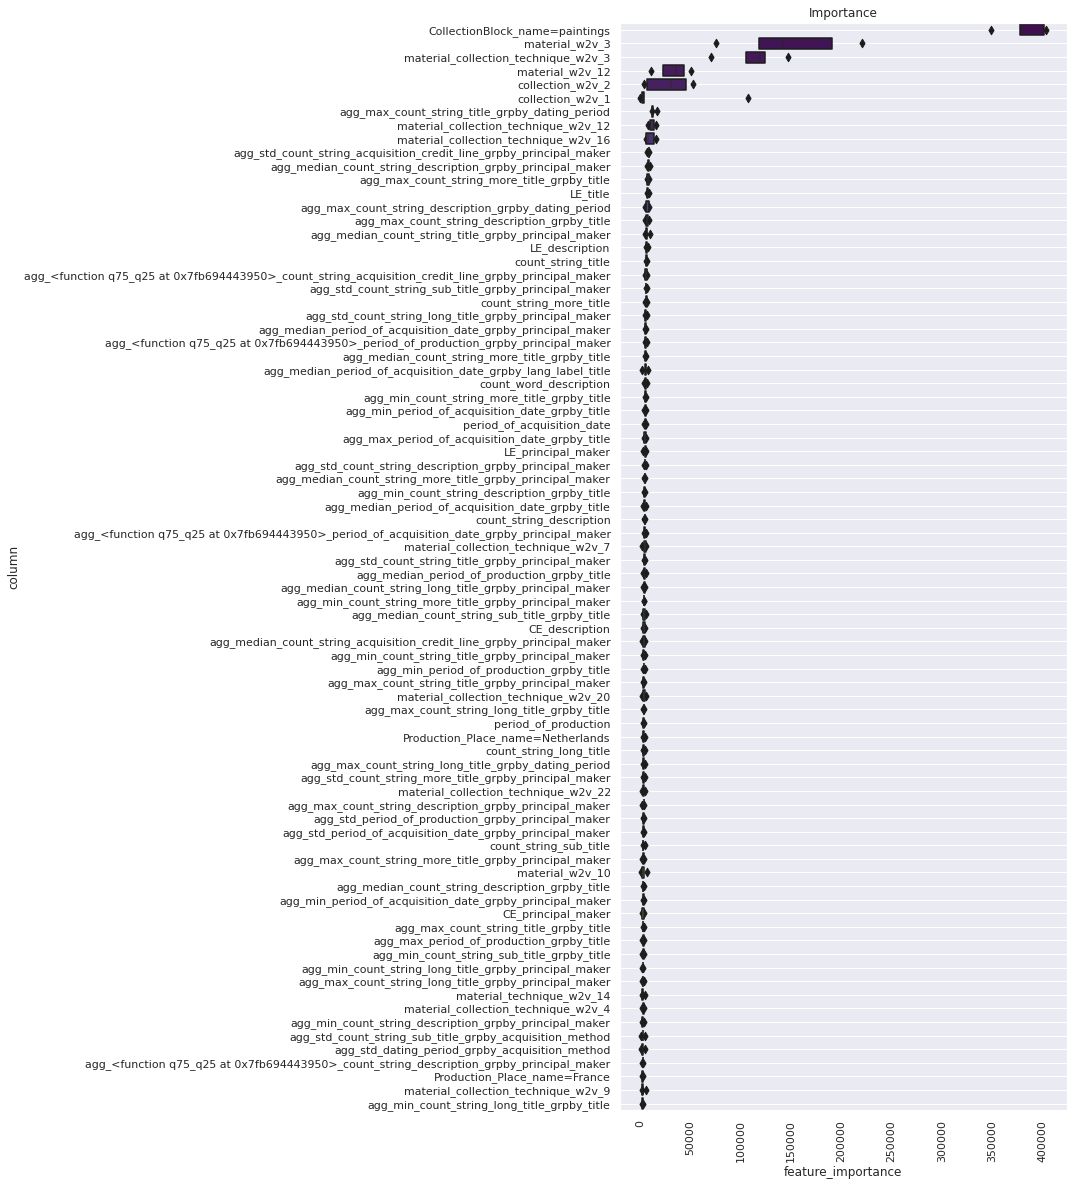

In [129]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

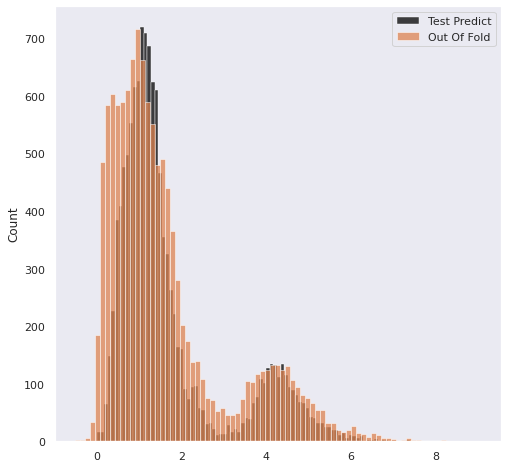

In [130]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred


pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [109]:
sub_df.to_csv(os.path.join(OUTPUT_PAHT, 'exp5.csv'), index=False)

In [131]:
train_feat_df.corr().head(20)

,dating_period,period_of_production,period_of_acquisition_date,count_string_title,count_string_description,count_word_description,count_string_acquisition_credit_line,count_word_acquisition_credit_line,count_string_long_title,count_string_more_title,count_string_sub_title,LE_acquisition_method,LE_principal_maker,LE_lang_label_title,LE_lang_label_description,LE_lang_label_long_title,LE_title,LE_description,CE_acquisition_method,CE_principal_maker,CE_lang_label_title,CE_lang_label_description,CE_title,CE_description,MaterialBlock_name=RC paper,MaterialBlock_name=baryta paper,MaterialBlock_name=canvas,MaterialBlock_name=cardboard,MaterialBlock_name=celluloid (cellulosic),MaterialBlock_name=copper (metal),MaterialBlock_name=glass,MaterialBlock_name=ink,MaterialBlock_name=leather,MaterialBlock_name=linen (material),MaterialBlock_name=metal,MaterialBlock_name=oil paint (paint),MaterialBlock_name=panel,MaterialBlock_name=paper,MaterialBlock_name=pencil,MaterialBlock_name=photographic paper,...,agg_min_count_string_title_grpby_dating_period,agg_min_count_string_description_grpby_dating_period,agg_min_count_string_sub_title_grpby_dating_period,agg_min_count_string_more_title_grpby_dating_period,agg_min_count_string_long_title_grpby_dating_period,agg_min_count_string_acquisition_credit_line_grpby_dating_period,agg_min_period_of_production_grpby_dating_period,agg_min_period_of_acquisition_date_grpby_dating_period,agg_std_count_string_title_grpby_dating_period,agg_std_count_string_description_grpby_dating_period,agg_std_count_string_sub_title_grpby_dating_period,agg_std_count_string_more_title_grpby_dating_period,agg_std_count_string_long_title_grpby_dating_period,agg_std_count_string_acquisition_credit_line_grpby_dating_period,agg_std_period_of_production_grpby_dating_period,agg_std_period_of_acquisition_date_grpby_dating_period,agg_median_count_string_title_grpby_dating_period,agg_median_count_string_description_grpby_dating_period,agg_median_count_string_sub_title_grpby_dating_period,agg_median_count_string_more_title_grpby_dating_period,agg_median_count_string_long_title_grpby_dating_period,agg_median_count_string_acquisition_credit_line_grpby_dating_period,agg_median_period_of_production_grpby_dating_period,agg_median_period_of_acquisition_date_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_count_string_title_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_count_string_description_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_count_string_sub_title_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_count_string_more_title_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_count_string_long_title_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_count_string_acquisition_credit_line_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_period_of_production_grpby_dating_period,agg_<function max_min at 0x7fb6a07e0b00>_period_of_acquisition_date_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_count_string_title_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_count_string_description_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_count_string_sub_title_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_count_string_more_title_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_count_string_long_title_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_count_string_acquisition_credit_line_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_period_of_production_grpby_dating_period,agg_<function q75_q25 at 0x7fb694443950>_period_of_acquisition_date_grpby_dating_period
dating_period,1.000000,-0.067771,-0.066017,0.132720,-0.384627,-0.395973,0.010276,0.005451,0.150853,-0.075256,-0.102555,0.048852,-0.027112,0.033271,-0.327865,0.044661,0.008357,-0.329847,0.005220,0.018069,0.136732,-0.349827,0.060395,0.357118,0.078358,0.136328,-0.075175,0.348442,0.032227,0.021272,0.186384,-0.018712,0.050643,0.0